# Various Figures for Deep Function Machines

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy
import scipy.signal
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

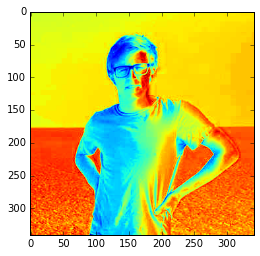

In [40]:
img=mpimg.imread('researcher.jpg')
lum_img = img[:,:,0]
imgplot = plt.imshow(lum_img)

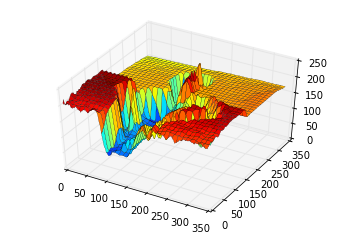

In [41]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Smoothing:
unp_img = lum_img[::-1,:]

def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

pimg = sgolay2d(unp_img, 11, 0)
x = np.array([x for x in range(lum_img.shape[0])])
y = np.array([y for y in range(lum_img.shape[1])])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
ax.plot_surface(xv,yv,pimg , cmap=cm.jet, linewidth=0.2)
ax.view_init(45,-60)
ax.dist =11
plt.show()


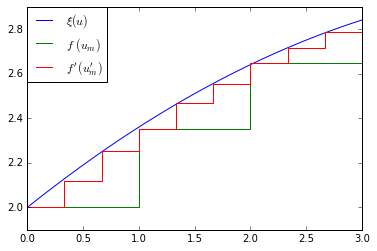

In [108]:
def piecewise_const(u, xi, num):
    x = np.linspace(0, 3, num=num)
    f = interp1d(u, xi, kind='nearest')(x)
    xflat, fflat = [], []
    for i, (a, fa) in enumerate(list(zip(x,f))[:-1]):
        xflat += [a, x[i+1]]
        fflat += [fa, fa]
        
    return xflat, fflat
    

u = np.linspace(0, 3, num=41,  endpoint=True)
xi = -(u/5-1)**2 +3 
x, f = piecewise_const(u, xi, 4)
xp, fp = piecewise_const(u, xi, 10)


    
l1, = plt.plot(u,xi, label='$\\xi(u)$')
l2, = plt.plot(x,f, label="$f\ (u_m)$")
l3, = plt.plot(xp,fp, label="$f'\ (u_m ')$")

plt.legend(loc=2, borderaxespad=0)
plt.savefig("plot_of_refinement.png", dpi=600)

In [ ]:
surface = 
pimg = sgolay2d(unp_img, 11, 0)
x = np.array([x for x in range(surface.shape[0])])
y = np.array([y for y in range(surface.shape[1])])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
ax.plot_surface(xv,yv,pimg , cmap=cm.jet, linewidth=0.2)
ax.view_init(45,-60)
ax.dist =11
plt.show()
